In [1]:
#hide
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier
Create a model that can classify images of 3 or 7.

## Pixels: The Foundations of Computer Vision
In order to understand what happens in a computer vision model, we first have to understand how computers handle images.

In [3]:
URLs.MNIST_SAMPLE
#output: 'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

> fastai: Function untar_data  
Download and uncompress a file
Docstring: Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`.

In [4]:
#download a sample of just 3s and 7s
path = untar_data(URLs.MNIST_SAMPLE) #class pathlib.PosixPath
print("Path: ", path)

Path:  /storage/data/mnist_sample


> fastai: `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. 

In [5]:
#path is '.' because use BASE_PATH attribute of Path
Path.BASE_PATH = path


#doc(path.ls())
path.ls() #returns a list, class fastcore.foundation.L

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

Common layout for ML datasets: separate folders for train and validation (and/or) test sets.

In [6]:
#look inside the the train set - a folder of 3s and a folder of 7s
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
#look inside folders - full of image files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

> python: `Image` class from the Python Imaging Library (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
print("Type: ", type(im3))
im3


Type:  <class 'PIL.PngImagePlugin.PngImageFile'>


In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [9]:
#numpy 
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
#the same thing as a PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values
> pandas: background_gradient

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


The background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments.)

This is how an image looks like to a computer.

Let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?


## First Try: Pixel Similarity
How about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This should make a good baseline.

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. 

#### Step 1. Get the average of pixel values for each of our two groups. 
and learn a lot of neat Python numeric programming tricks!

> python: List Comprehensions:  
`new_list = [f(o) for o in a_list if o>0]`   
3 parts: 
    1) the collection you are iterating over (`a_list`)  
    2) an optional filter (`if o>0`)  
    3) something to do to each element (`f(o)`)  
    It's way faster than loops.

In [12]:
#create a tensor containing all 3s and 7s stacked together
# use Python list comprehension -> plain list of the single image tensors
seven_tensors = [tensor(Image.open(o)) for o in sevens] #list of torch.Tensor
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

A list of 2D torch.Tensors

In [13]:
three_tensors[1].shape

torch.Size([28, 28])

>Jupyter and images:  
type PIL images - Jupyter by default will display as images  
type tensor - Jupyter by default will print as values  
Use fastai `show_image` function to display tensor as image

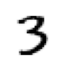

In [14]:
#check if image looks ok
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. 
>PyTorch: Use function `stack` .

>PyTorch: Casting types  
Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. We cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255 #class 'torch.Tensor'
stacked_threes = torch.stack(three_tensors).float()/255
print("type: ", type(stacked_sevens))
stacked_threes.shape

type:  <class 'torch.Tensor'>


torch.Size([6131, 28, 28])

In my head (not trained with PyTorch yet) it's a 3D torch.Tensor    
The correct term is rank-3 tensor.

In [16]:
#tensor rank
len(stacked_threes.shape)

3

In [17]:
#can also get rank with 'ndim'
stacked_threes.ndim

3

> PyTorch: Tensor Vocab  
*rank* is the number of axes (or dimensions) in a tensor  
*shape* is the size of each axis of a tensor.
    - In this case, we can see that we have 6,131 images, each of size 28×28 pixels  
*length* of a tensor's shape is its rank. 

Using the term *dimension* may lead to confustion. When confused, it's helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

#### Compute what the ideal 3 looks like
We calculate the mean of all the image tensors by taking the mean along dim 0 of our rank-3 tensor. This is the dim that indexes over all the images.

#### NOT 
mean() returns a single number, the average pixel across the whole cube, the whole rank-3 tensor.

In [18]:
stacked_threes.mean()

tensor(0.1415)

mean(0) is the mean over 0 axis, the mean across the images.  In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image.

In [19]:
mean3 = stacked_threes.mean(0)
print("typical 3 shape: ", mean3.shape)
print("typical 3 preview: \n", mean3[2:10, 2:10])


typical 3 shape:  torch.Size([28, 28])
typical 3 preview: 
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.5991e-05, 4.8676e-04, 7.7331e-04, 1.4468e-03, 2.9788e-03, 5.6486e-03],
        [3.2621e-05, 1.5607e-04, 1.3995e-03, 5.7854e-03, 1.3664e-02, 3.0111e-02, 5.5401e-02, 9.0316e-02],
        [5.7567e-05, 1.5204e-03, 8.8908e-03, 2.7837e-02, 6.1064e-02, 1.1271e-01, 1.8688e-01, 2.8025e-01],
        [3.0063e-04, 5.8174e-03, 2.4498e-02, 5.9899e-02, 1.2038e-01, 2.0755e-01, 3.1939e-01, 4.3547e-01],
        [4.5414e-04, 9.7409e-03, 3.7895e-02, 8.2921e-02, 1.5382e-01, 2.4157e-01, 3.3767e-01, 4.2682e-01],
        [5.3985e-04, 1.1943e-02, 4.0899e-02, 7.8775e-02, 1.3442e-01, 1.9457e-01, 2.5074e-01, 2.9489e-01],
        [6.4603e-04, 9.1461e-03, 2.9371e-02, 5.4969e-02, 8.9482e-02, 1.1955e-01, 1.4173e-01, 1.5585e-01]])


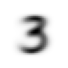

In [20]:
show_image(mean3);

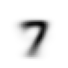

In [21]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This is what peak number performance looks like. We see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

#### Pick an arbitrary 3 and measure its *distance* from our "ideal digits."

How would you calculate how similar a particular image is to each of our ideal digits? 

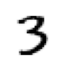

In [22]:
#a sample 3
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- *L1 norm* or the *mean absolute difference*  
Take the mean of the *absolute value* of differences  
- *L2 norm* or the *root mean squared error* (RMSE)  
Take the mean of the *square* of differences and then take the *square root* (which undoes the squaring)

> Math. Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

In [23]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [24]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

#### Loss Functions
>PyTorch: provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai).  
   - *mean absolute value* (in math it's called the *L1 norm*) `mae`    
   - *mean squared error* `mse` 
>Math vs Code: Loss Funcitons 
a and b are tensors  
   - L1 loss is (a-b).abs().mean()
   - L2 loss is ((a-b)**2).mean().sqrt()

In [25]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors
two very important data structures  
Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

[NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

In [26]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [27]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [28]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [29]:
#select a row
tns[1]

tensor([4, 5, 6])

In [30]:
#select a column
tns[:,1]

tensor([2, 5])

In [31]:
tns[1,1:3]

tensor([5, 6])

In [32]:
#use the standard operators such as +, -, *, /:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

>python and PyTorch diff: 
python type() tells you it's torch.Tensor  
If want to know what type of Tesnsor, vs PyTorch tns.type()

In [33]:
print(type(tns))
# Tensors have a type
print(tns.type())

<class 'torch.Tensor'>
torch.LongTensor


In [34]:
#And will automatically change type as needed, for example from int to float:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting
Reminder: Our model is comparing a digit (image) to the mean.

Recall that a metric is a number that is calculated based on the predictions of our model vs the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions: mse or mae, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use *accuracy* as the metric for classification models.

As we've discussed, we want to calculate our metric over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

#### Get a validation set
Let's create tensors for our 3s and 7s from MNIST sample, validation directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image

In [35]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Good habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

#### Prediction function
We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an experssion very similar to the one we wrote in the last section:

In [36]:
#mean over last 2 dims
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [37]:
#$ac my question, why .mean((-1,-2), not just mean()
def my_mnist_distance(a,b): return (a-b).abs().mean()
mnist_distance(a_3, mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 `mean_3` and the arbitrary sample 3 `a_3`, which are both single-image tensors with a shape of `[28,28]`.

#### Overall accuracy (on validation set)
In order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for _every_ image in the validation set. 

We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, `valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tens`, the tensor that represents the 3s validation set:

In [38]:
#$acmytry delete ok
valid_3_dist = [mnist_distance(i, mean3) for i in valid_3_tens] #class list
np.mean(valid_3_dist)

0.12963918

In [39]:
#$acmytry delete ok
my_valid_3_dist = [my_mnist_distance(i, mean3) for i in valid_3_tens] #class list
np.mean(my_valid_3_dist)

0.12963918

In [40]:
print(mnist_distance(valid_3_tens, mean3).mean())
print(mnist_distance(valid_3_tens, mean7).mean())

tensor(0.1296)
tensor(0.1596)


In [41]:
print(my_mnist_distance(valid_3_tens, mean3).mean())
print(my_mnist_distance(valid_3_tens, mean7).mean())

tensor(0.1296)
tensor(0.1596)


In [42]:
#$ac end of acmytry $acdelete

>SuperTrick: Broadcasting  
(python, PyTorch)  
automatically handles operation between two tensors of different ranks

In [43]:
print("Validation dataset (tensor) shape: ", valid_3_tens.shape)
print("Typical 3 (tensor) shape: ", mean3.shape)

Validation dataset (tensor) shape:  torch.Size([1010, 28, 28])
Typical 3 (tensor) shape:  torch.Size([28, 28])


In [44]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
#instead of returning a single number, it returns n numbers
valid_3_dist, valid_3_dist.shape

(tensor([0.1290, 0.1223, 0.1380,  ..., 0.1337, 0.1132, 0.1097]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result.

#### Python operations

In [45]:
#element-wise operation, when shapes match
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

>SuperTrick: Broadcasting

Here, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. 

In [46]:
#when shapes don't match
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

Note: 
#### how broadcasting is implemented
which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*



Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.

#### Predict a 3
We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [47]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [48]:
#test on our example case
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [49]:
#test it on the full validation set of 3s
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

#### Salculate the accuracy for each of the 3s and 7s 
by taking the average of that function for all 3s and its inverse for all 7s

In [50]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

However, 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!

To do better, perhaps it is time to try a system that does some real learning—that is, that can automatically modify itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

## Stochastic Gradient Descent (SGD)

 Arthur Samuel described machine learning as

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8

```
def pr_eight(x,w) = (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated in $actodo link<<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems!

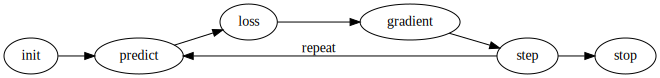

In [51]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

#### Gradient Descent - simple case
Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

In [52]:
def f(x): return x**2

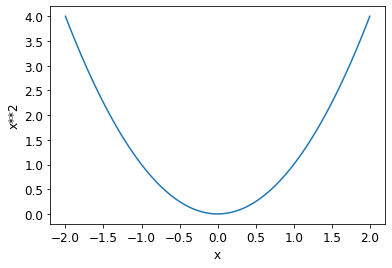

In [53]:
#graph
plot_function(f, 'x', 'x**2')


The sequence of steps:  
- Point1 - picking some random value for a parameter, and calculating the value of the loss.  
- Point2 - increase or decreas our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point.  
- Point3 - change our weight by a little in the direction of the slope, calculate our loss and adjustment again.  

Repeat this a few times. Eventually, we will get to the lowest point on our curve.

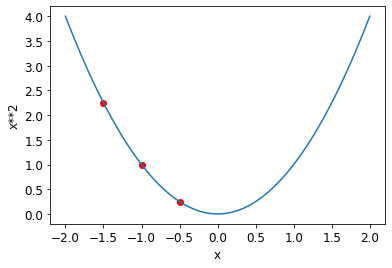

In [59]:
#graph
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');
plt.scatter(-1, f(-1), color='red');
plt.scatter(-0.5, f(-0.5), color='red');

### Calculating Gradients

The one magic step is the bit where we calculate the gradients. The gradients will tell us how much we have to change each weight to make our model better.  We use calculus as a performance optimization.

> Math: calculus - the *derivative* of a function tells you how much a change in its parameterss will change its result.  
Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro).

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

PyTorch is able to automatically compute the derivative of nearly any function! 

#### Example of gradients
- A scalar tensor value which we want gradients at

In [80]:
xt

tensor(3., requires_grad=True)

In [92]:
#pick a tensor value which we want gradients at
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

>PyTorch: special method `requires_grad_`? The magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.  

In deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. 

In [93]:
#calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed
yt = f(xt)
yt

tensor(9., grad_fn=<SumBackward0>)

In [94]:
#tell PyTorch to calculate the gradients for us
yt.backward()

>PyTorch: The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. 

Later, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

In [95]:
#view the gradients by checking the grad attribute of our tensor
xt.grad

tensor(6.)

With calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!

- Repeat with a vector argument for our function:

In [101]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [102]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [103]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Our gradients are `2*xt`, as we'd expect!

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate
The basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1.  More later on picking LR.  

Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*.

### An End-to-End SGD Example

In [104]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

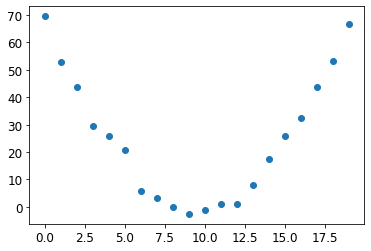

In [136]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [156]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [157]:
def mse(preds, targets): return ((preds-targets)**2).mean()

In [141]:
#$ac mytry
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [140]:
speed

tensor([69.5480, 52.9950, 43.7120, 29.4057, 25.8371, 20.7879,  5.8346,  3.3291, -0.1814, -2.5553, -1.0623,  0.9109,  1.0896,  8.0121, 17.5867, 25.6877, 32.5559, 43.8979, 53.0693, 66.5368])

In [192]:
orig_params

tensor([0.3355, 0.2469, 0.0324], grad_fn=<CloneBackward>)

In [158]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

In [160]:
y_hat = f(time, params)
y_hat

tensor([  -0.5359,   -2.5118,   -7.0561,  -14.1689,  -23.8500,  -36.0996,  -50.9176,  -68.3041,  -88.2589, -110.7822, -135.8739, -163.5340, -193.7626, -226.5595, -261.9249, -299.8587, -340.3610,
        -383.4316, -429.0707, -477.2782], grad_fn=<AddBackward0>)

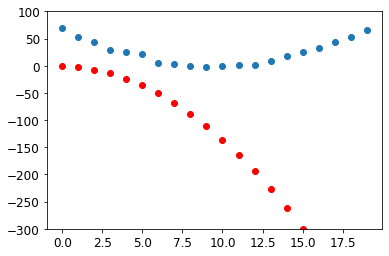

In [161]:
show_preds(y_hat)

In [145]:
error = y_hat - speed
error_sqrd = error**2
error_mse = error_sqrd.mean()
error_mse

tensor(1656.8734, grad_fn=<MeanBackward0>)

In [162]:
error2_mse = mse(y_hat, speed)
error2_mse

tensor(60909.1367, grad_fn=<MeanBackward0>)

In [163]:
error2_mse.backward()
params.grad

tensor([-82343.2422,  -5287.4863,   -381.1137])

In [164]:
lr = 1e-5
lr

1e-05

In [165]:
params * lr

tensor([-1.2842e-05, -6.9168e-06, -5.3595e-06], grad_fn=<MulBackward0>)

In [166]:
params.data -= params.grad.data*lr
params.grad = None

In [167]:
y_hat = f(time, params)
y_hat

tensor([  -0.5321,   -1.6317,   -3.6529,   -6.5956,  -10.4598,  -15.2456,  -20.9530,  -27.5819,  -35.1324,  -43.6045,  -52.9981,  -63.3133,  -74.5500,  -86.7083,  -99.7881, -113.7895, -128.7125,
        -144.5570, -161.3231, -179.0107], grad_fn=<AddBackward0>)

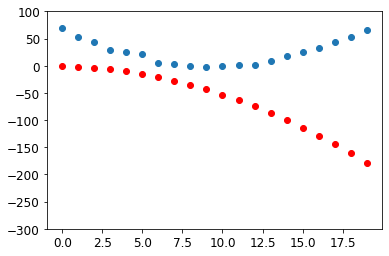

In [168]:
show_preds(y_hat)

In [169]:
error2_mse = mse(y_hat, speed)
error2_mse

tensor(12057.8418, grad_fn=<MeanBackward0>)

In [170]:
error2_mse.backward()
params.grad

tensor([-35819.6836,  -2301.7629,   -176.7137])

In [171]:
params.data -= params.grad.data*lr
params.grad = None

In [ ]:
#$acdo compared -> finish and doc
y_hat = f(time, params)
print("y_hat", y_hat)
error2_mse = mse(y_hat, speed)
print("loss",error2_mse)

#backstep and get gradient(s)
error2_mse.backward()
print("gradients",params.grad)
#adjust
params.data -= lr * params.grad.data
params.grad = None

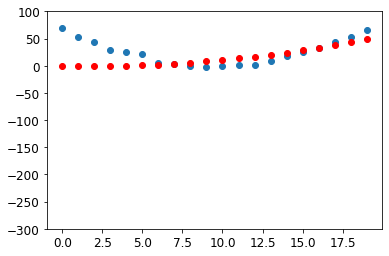

In [183]:
show_preds(y_hat)

In [ ]:
#$ac mytry

#### Step 1: Initialize the parameters

In [184]:
params = torch.randn(3).requires_grad_()

In [185]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [186]:
preds = f(time, params)

In [187]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

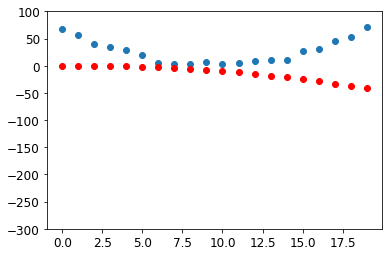

In [122]:
show_preds(preds)

#### Step 3: Calculate the loss

In [188]:
loss = mse(preds, speed)
loss

tensor(1999.2000, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [189]:
loss.backward()
params.grad

tensor([12322.4492,   802.3890,    37.9309])

In [190]:
params.grad * 1e-5

tensor([0.1232, 0.0080, 0.0004])

In [191]:
params

tensor([0.3355, 0.2469, 0.0324], requires_grad=True)

#### Step 5: Step the weights. 

In [193]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [195]:
preds = f(time,params)
mse(preds, speed)

tensor(905.0928, grad_fn=<MeanBackward0>)

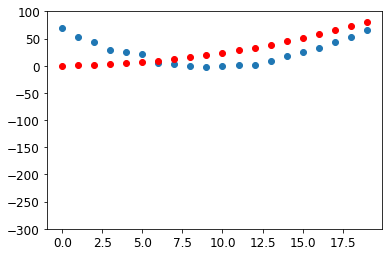

In [196]:
show_preds(preds)

In [197]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [198]:
for i in range(10): apply_step(params)

905.0927734375
698.0510864257812
658.869384765625
651.4515380859375
650.0447998046875
649.775390625
649.72119140625
649.7078857421875
649.7020263671875
649.6976318359375


In [199]:
#hide
params = orig_params.detach().requires_grad_()

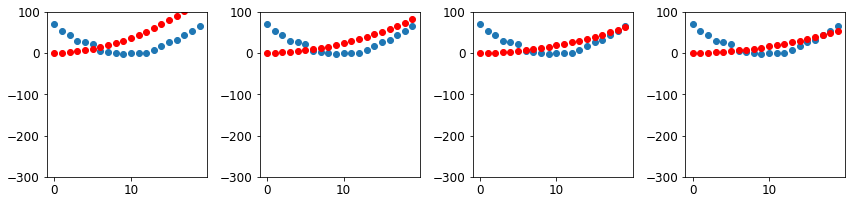

In [200]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

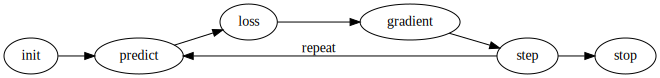

In [201]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
(train_x[0]*weights.T).sum() + bias

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

In [ ]:
corrects.float().mean().item()

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

In [ ]:
mnist_loss(prds,trgts)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

### Sigmoid

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

## Putting It All Together

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

In [ ]:
#$acxtra
#$acmytry delete ok
dist_valid3_abs3 = [(i - mean3).abs().mean() for i in valid_3_tens]
dist_valid3_abs7 = [(i - mean7).abs().mean() for i in valid_3_tens]
diff3_abs = tensor(dist_valid3_abs3) - tensor(dist_valid3_abs7)
#dist_valid3_sqr = ((valid_3_tens[1] - mean3)**2).mean().sqrt()
#dist_valid3_abs3 - dist_valid3_abs7
diff3_abs